# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

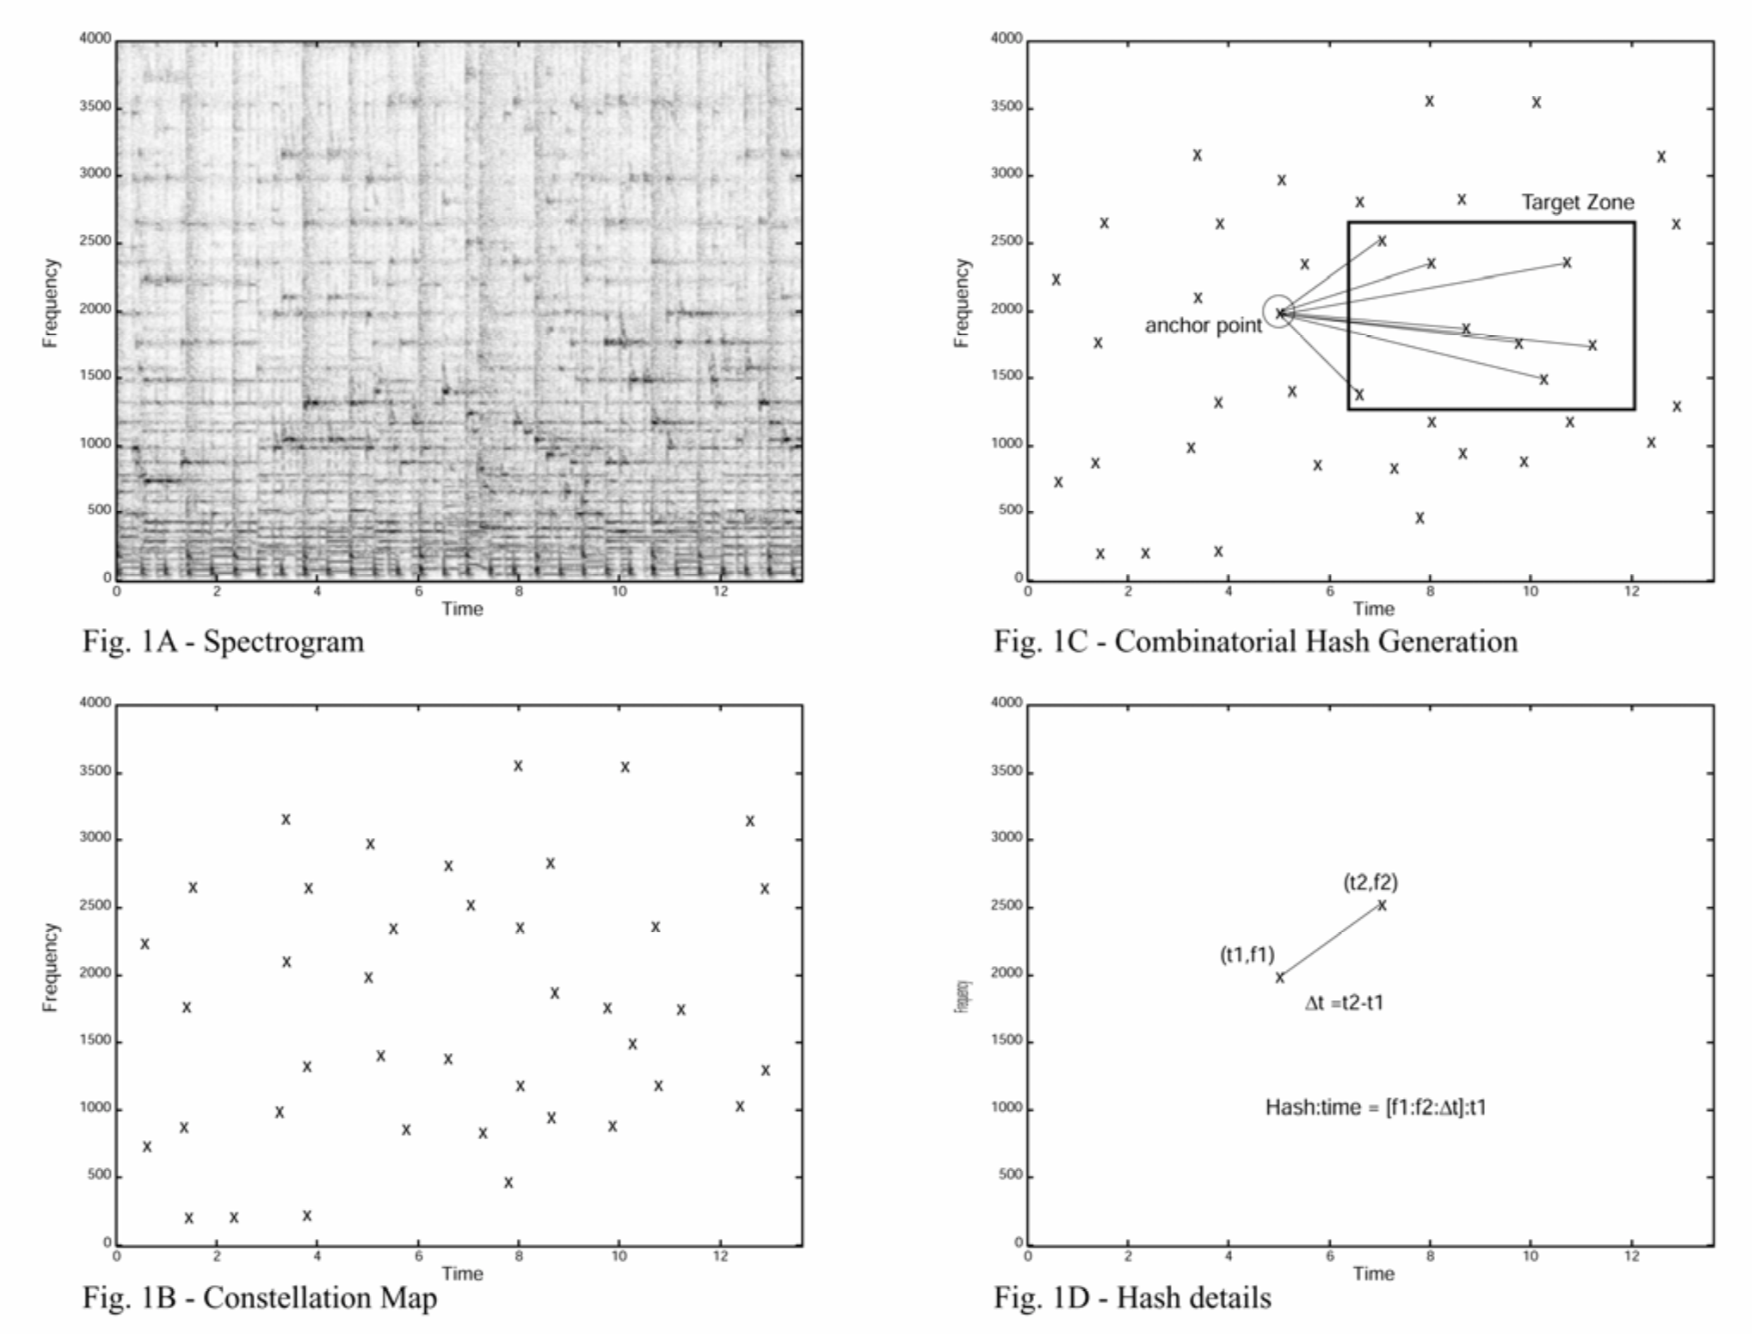

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


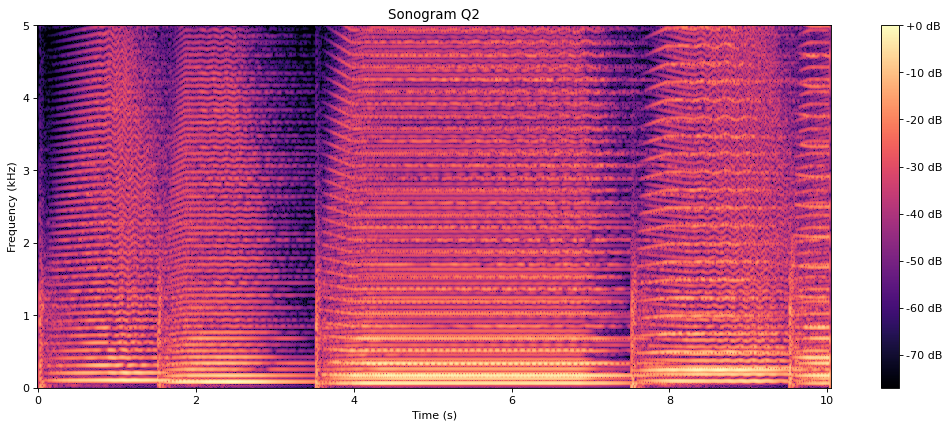

In [1]:
# add your code below
import numpy as np
import matplotlib.pyplot as plt
import pydub
import math
import librosa
import os
from scipy import signal

path = 'C:\\Users\\ioric\\Desktop\\KTH\\Music Informatics\\Labs\\Lab4\\'
queries_folder = path + 'queries\\'
kikibouba_test_folder = path + 'KikiBoubadata\\kikibouba_test\\'
kikibouba_train_folder = path + 'KikiBoubadata\\kikibouba_train\\'
#print(kikibouba_train_folder)

window_lenght = 0.050
hop_size_window = 0.010
zeropadding = 4


#get the query
q2_file = queries_folder + 'Q2.wav'
q2 = pydub.AudioSegment.from_file(q2_file, format='wav')
q2_array = (np.array(q2.get_array_of_samples()) / 2**16) * 2
q2_frame_rate = q2.frame_rate
q2_frame_size = int(q2_frame_rate * window_lenght)
q2_nfft = zeropadding * q2_frame_size
q2_hop_size = int(hop_size_window * q2_frame_rate)
q2_frame_rate_nov = q2_frame_rate / q2_hop_size

#choose channel left
if q2.channels == 2:
    left_channel_q2= q2_array[::2]
    q2_array = left_channel_q2

#get time axis
time = np.linspace(0, len(q2_array)/(q2_frame_rate), num=len(q2_array))

#do the stft and find db magnitude
q2_frequencies, q2_times, q2_stft = signal.stft(q2_array, fs=q2_frame_rate, window='hann', nperseg= q2_frame_size, noverlap=(q2_frame_size - q2_hop_size), nfft=q2_nfft)  
q2_frequencies_khz = q2_frequencies / 1000  #for kHz
q2_stft_magn = np.abs(q2_stft)
max_stft = np.max(q2_stft_magn)
q2_stft_db = librosa.amplitude_to_db(q2_stft_magn, ref=max_stft)
#q2_stft_db = librosa.amplitude_to_db(np.abs(q2_stft), ref=max_stft)
#print(q2_stft_db.shape[0])

plt.figure(figsize=(16, 6), dpi=80)
plt.title('Sonogram Q2')
plt.ylim((0,5))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.pcolormesh(q2_times, q2_frequencies_khz, q2_stft_db, cmap='magma')  #feel magma looks good
plt.colorbar(format='%+0.0f dB')
plt.show()

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [3]:
# add your code below
delta_t = 0.1
num_bands = 25
delta_f = ((q2_frame_rate/2)/num_bands)
final_instance = len(q2_times) -1
n_times = int(np.floor(q2_times[final_instance] / delta_t)) 

#now initialize the grid
found_anchors = []
#function for indexes
def find_indexes_lower_upper(value, choice, q2_tf, delta):
    if choice== 'band':

        part_considered = np.where((q2_tf >= (value * delta)) & (q2_tf  < ((value + 1) * delta))==True)[0]
        minimum_index = part_considered[0]
        final_index = len(part_considered) -1
        maximum_index = part_considered[final_index]
        
    if choice == 'time':
        part_considered = np.where((q2_tf >= (value * delta)) & (q2_tf  < ((value + 1) * delta))==True)[0]
        minimum_index = part_considered[0]
        final_index = len(part_considered) -1
        maximum_index = part_considered[final_index]

    return minimum_index, maximum_index, part_considered
        

for band in range(num_bands):
    for time in range(n_times):
                
        min_time, max_time, time_part = find_indexes_lower_upper(time, 'time', q2_times, delta_t)
        min_freq, max_freq, freq_part = find_indexes_lower_upper(band, 'band', q2_frequencies, delta_f)
                
        considered_part_stft = q2_stft_db[min_freq:max_freq, min_time:max_time]
        flat_index = np.argmax(considered_part_stft, axis=None)
        best_index_all = np.unravel_index(flat_index, considered_part_stft.shape)
        time_max_max = time_part[best_index_all[1]]
        freq_max_max = freq_part[best_index_all[0]]
        
        #finally finds anchor and appends it
        found_anchors.append([q2_frequencies[freq_max_max], q2_times[time_max_max]])
            
q2_anchor = np.array(found_anchors)
q2_anchor_times = q2_anchor[:, 1]
q2_anchor_frequencies = q2_anchor[:, 0]
q2_anchor_frequencies_khz = q2_anchor_frequencies/1000

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

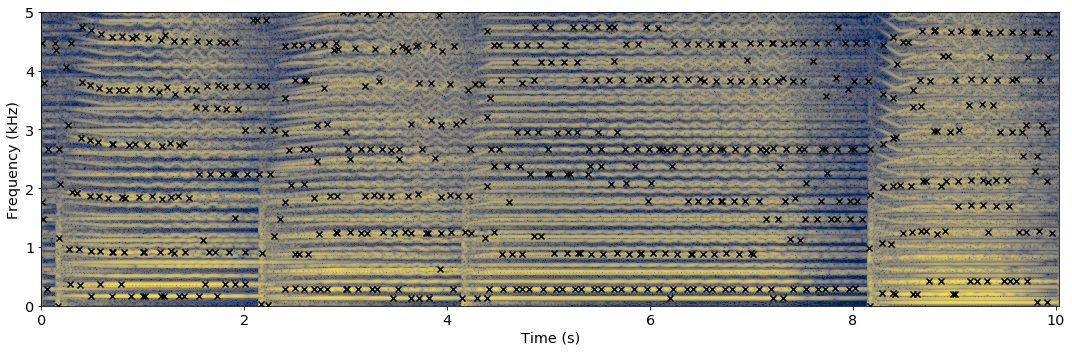

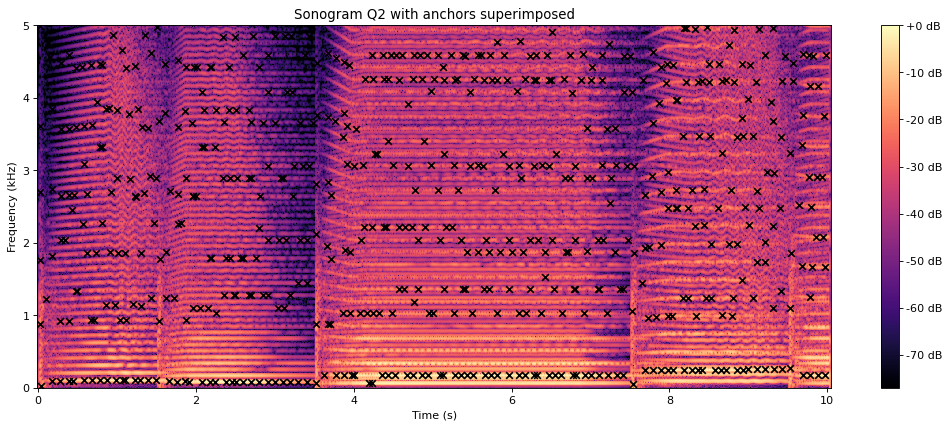

In [3]:
# add your code below
plt.figure(figsize=(16, 6), dpi=80)
plt.pcolormesh(q2_times, q2_frequencies_khz, q2_stft_db, cmap='magma')
plt.colorbar(format='%+0.0f dB')
plt.scatter(q2_anchor_times, q2_anchor_frequencies_khz, c='k', marker='x')
plt.title('Sonogram Q2 with anchors superimposed')
plt.ylim((0, 5))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

### Considerations
***
As expected the anchors appear in the points where there is more energy. With this colormap the anchors tend to be located in yellow to red colours, the anchors are located on darker colours only if there are no other higher energy points around. They capture specific moments or events in the audio that stand out, rather than representing the entire audio waveform. In comparison to the original audio or the Short-Time Fourier Transform representation of the audio, it is easier in this way to capture and see significant audio events at a glance. 
***

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [4]:
# add your code below
def compute_fingerprint(anchors):
    hashes = []
    num_anchors = len(anchors)
    for i in range(num_anchors):
        for j in range(i + 1, num_anchors):
            f1, t1 = anchors[i]
            f2, t2 = anchors[j]
            
            # target zone for anchor i definition
            target_time_start = t1 + 0.1 
            target_time_end = target_time_start + 0.1 + 0.5 
            target_freq_start = f1 * (2 ** (-0.5))  # half-octave below f1
            target_freq_end = f1 * (2 ** 0.5)    # half-octave above f1
            
            if (target_time_start <= t2 <= target_time_end) and (target_freq_start <= f2 <= target_freq_end):
                
                # Compute hash
                hash_f1 = int(f1)
                hash_f2 = int(f2)
                time_diff = t2 - t1


                hash_tuple = (hash_f1, hash_f2, time_diff)
                hashes.append((t1, hash_tuple))   #fingerprint
    
    return hashes

q2_fingerprint = compute_fingerprint(q2_anchor)

#print only start part of hashes to check
print('First 10 fingerprint hashes structure example:')
print(q2_fingerprint[0:10])

First 10 fingerprint hashes structure example:
[(0.18, (100, 100, 0.20999999999999996)), (0.18, (100, 100, 0.26999999999999996)), (0.18, (100, 105, 0.41)), (0.18, (100, 105, 0.51)), (0.18, (100, 105, 0.6099999999999999)), (0.18, (100, 105, 0.7)), (0.27999999999999997, (100, 100, 0.10999999999999999)), (0.27999999999999997, (100, 100, 0.16999999999999998)), (0.27999999999999997, (100, 105, 0.31)), (0.27999999999999997, (100, 105, 0.41))]


# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

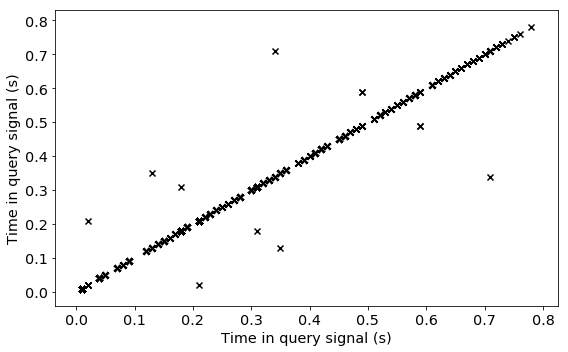



In [5]:
# add your code below
import tqdm
import multiprocessing
def compute_anchor_from_file(filename, start = 0, seconds_segment = 0):
    path = 'C:\\Users\\ioric\\Desktop\\KTH\\Music Informatics\\Labs\\Lab4\\'
    queries_folder = path + 'queries\\'
    kikibouba_test_folder = path + 'KikiBoubadata\\kikibouba_test\\'
    kikibouba_train_folder = path + 'KikiBoubadata\\kikibouba_train\\'
    #print(kikibouba_train_folder)
    
    window_lenght = 0.050
    hop_size_window = 0.010
    zeropadding = 4
    
    
    #get the query
    q_file = queries_folder + filename
    q = pydub.AudioSegment.from_file(q_file, format='wav')
    q_array = (np.array(q.get_array_of_samples()) / 2**16) * 2
    q_frame_rate = q.frame_rate
    q_frame_size = int(q_frame_rate * window_lenght)
    q_nfft = zeropadding * q_frame_size
    q_hop_size = int(hop_size_window * q_frame_rate)
    q_frame_rate_nov = q_frame_rate / q_hop_size
    
    
    #choose channel left
    if q.channels == 2:
        left_channel_q= q_array[::2]
        q_array = left_channel_q
    
    #get time axis
    time = np.linspace(0, len(q_array)/(q_frame_rate), num=len(q_array))


    if seconds_segment != 0:
        stop = start + seconds_segment
        time = np.linspace(start, stop, int(np.ceil(q_frame_rate * seconds_segment)))
        stop_index = int(np.ceil(q_frame_rate* stop))
        start_index = int(np.ceil(q_frame_rate* start))
        q_array = q_array[start_index:stop_index]


        
    #do the stft and find db magnitude
    q_frequencies, q_times, q_stft = signal.stft(q_array, fs=q_frame_rate, window='hann', nperseg= q_frame_size, noverlap=(q_frame_size - q_hop_size), nfft=q_nfft)  
    q_frequencies_khz = q_frequencies / 1000  #for kHz
    q_stft_magn = np.abs(q_stft)
    max_stft = np.max(q_stft_magn)
    q_stft_db = librosa.amplitude_to_db(q_stft_magn, ref=max_stft)
    #q_stft_db = librosa.amplitude_to_db(np.abs(q2_stft), ref=max_stft)
    #print(q_stft_db.shape[0])


    delta_t = 0.1
    num_bands = 25
    delta_f = ((q_frame_rate/2)/num_bands)
    final_instance = len(q_times) -1
    n_times = int(np.floor(q_times[final_instance] / delta_t)) 
    
    #now initialize the grid
    found_anchors = []
    #function for indexes
    def find_indexes_lower_upper(value, choice, q_tf, delta):
        if choice== 'band':
           
            part_considered = np.where((q_tf >= (value * delta)) & (q_tf  < ((value + 1) * delta))==True)[0]
            minimum_index = part_considered[0]
            final_index = len(part_considered) -1
            maximum_index = part_considered[final_index]
            
        if choice == 'time':
            part_considered = np.where((q_tf >= (value * delta)) & (q_tf  < ((value + 1) * delta))==True)[0]
            minimum_index = part_considered[0]
            final_index = len(part_considered) -1
            maximum_index = part_considered[final_index]
    
        return minimum_index, maximum_index, part_considered
            
    
    for band in range(num_bands):
        for time in range(n_times):
                    
            min_time, max_time, time_part = find_indexes_lower_upper(time, 'time', q_times, delta_t)
            min_freq, max_freq, freq_part = find_indexes_lower_upper(band, 'band', q_frequencies, delta_f)
                    
            considered_part_stft = q_stft_db[min_freq:max_freq, min_time:max_time]
            flat_index = np.argmax(considered_part_stft, axis=None)
            best_index_all = np.unravel_index(flat_index, considered_part_stft.shape)
            time_max_max = time_part[best_index_all[1]]
            freq_max_max = freq_part[best_index_all[0]]
            
            #finally finds anchor and appends it
            found_anchors.append([q_frequencies[freq_max_max], q_times[time_max_max]])
                
    q_anchor = np.array(found_anchors)
    q_anchor_times = q_anchor[:, 1]
    q_anchor_frequencies = q_anchor[:, 0]
    q_anchor_frequencies_khz = q_anchor_frequencies/1000

    return q_anchor

def compute_fingerprint(anchors):
    hashes = []
    num_anchors = len(anchors)
    for i in range(num_anchors):
        for j in range(i + 1, num_anchors):
            f1, t1 = anchors[i]
            f2, t2 = anchors[j]
            
            # target zone for anchor i definition
            target_time_start = t1 + 0.1 
            target_time_end = target_time_start + 0.1 + 0.5 
            target_freq_start = f1 * (2 ** (-0.5))  # half-octave below f1
            target_freq_end = f1 * (2 ** 0.5)    # half-octave above f1
            
            if (target_time_start <= t2 <= target_time_end) and (target_freq_start <= f2 <= target_freq_end):
                
                # Compute hash
                hash_f1 = int(f1)
                hash_f2 = int(f2)
                time_diff = t2 - t1
                #time_diff = round(t2 - t1, 2)  # Round to 2 decimal places

                hash_tuple = (hash_f1, hash_f2, time_diff)
                hashes.append((t1, hash_tuple))   #fingerprint
    
    return hashes

def find_matching_hashes_slow(q_fingerprint1, q_fingerprint2):
    matches = []  #times of matching hashes
    for i in tqdm.tqdm(range(3), desc = 'Progress'):
        for q_time1, q_hash1 in q_fingerprint1:
            for q_time2, q_hash2 in q_fingerprint2:
                # Calculate the sum 
                difference = sum(abs(a - d) for a, d in zip(q_hash1, q_hash2))
                if difference <= 0:                    # Check if there is a match
                    matches.append((q_time1, q_time2))


    return matches

def find_matching_hashes_medium_slow(q_fingerprint1, q_fingerprint2):
    matches = []  
    q_hash1 = np.array([q[1] for q in q_fingerprint1])
    q_hash2 = np.array([q[1] for q in q_fingerprint2])

    batch_size = 10000

    for i in tqdm.tqdm(range(10), desc='Progress'):
        for start1 in range(0, len(q_hash1), batch_size):
            end1 = start1 + batch_size
            batch_q_hash1 = q_hash1[start1:end1]

            for start2 in range(0, len(q_hash2), batch_size):
                end2 = start2 + batch_size
                batch_q_hash2 = q_hash2[start2:end2]

                # sum of absolute differences for the batch
                batch_hash_diff = np.abs(batch_q_hash1[:, np.newaxis] - batch_q_hash2).sum(axis=2)

                # matching indices within the batch
                matching_indices = np.argwhere(batch_hash_diff <= 0)

                for idx in matching_indices:
                    q_time1, q_time2 = q_fingerprint1[start1 + idx[0]][0], q_fingerprint2[start2 + idx[1]][0]
                    matches.append((q_time1, q_time2))

    return matches


def find_matching_hashes(q_fingerprint1, q_fingerprint2):
    matches = []  # times of matching hashes
    q_hash1 = np.array([q[1] for q in q_fingerprint1])
    q_hash2 = np.array([q[1] for q in q_fingerprint2])

    for i in tqdm.tqdm(range(5), desc='Progress'):
        hash_diff = np.abs(q_hash1[:, np.newaxis] - q_hash2).sum(axis=2)
        matching_indices = np.argwhere(hash_diff <= 0)

        for idx in matching_indices:
            q_time1, q_time2 = q_fingerprint1[idx[0]][0], q_fingerprint2[idx[1]][0]
            matches.append((q_time1, q_time2))

    return matches

In [17]:
q2_anchor_1sec = compute_anchor_from_file('Q2.wav', 4, 1) #start at 4 seconds and duration 1 second
q2_fingerprint_1sec = compute_fingerprint(q2_anchor_1sec)

In [ ]:
comparison_1sec = find_matching_hashes(q2_fingerprint_1sec, q2_fingerprint_1sec)

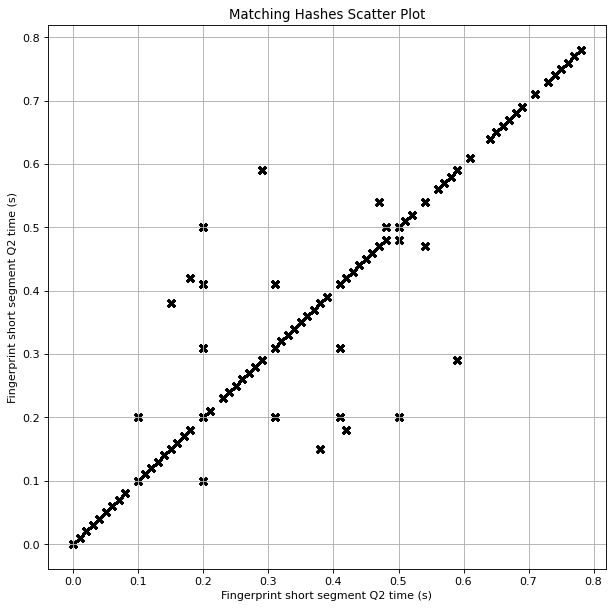

In [19]:
f1_times_same1, f2_times_same2 = zip(*comparison_1sec)
plt.figure(figsize=(9, 9), dpi=80)
plt.scatter(f1_times_same1, f2_times_same2, marker='x', color='k')
plt.xlabel('Fingerprint short segment Q2 time (s)')
plt.ylabel('Fingerprint short segment Q2 time (s)')
plt.title('Matching Hashes Scatter Plot')
plt.grid()
plt.show()

### Considerations

*** 
As expected there are matches along the diagonal since the audio files used are the same and are restricted to the same second. The matches happen along the diagonal since at equal times logically follow equal hashes, and the matches are correctly reported in the plot. There are some matches outside the diagonal and it may due to to the fact that some hashes have similarities in the frequency contents and in the time delta that lead the sum of the magnitude differences between the dimensions of the hashes to be zero. Those spurious matches could be limited by upgrading the way the hashes are created, maybe altering the target zone, but overall are very few compared to the points in the main diagonal. 
***

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [ ]:
# add your code below
comparison_fingerprints_same_audio = find_matching_hashes(q2_fingerprint, q2_fingerprint_1sec)

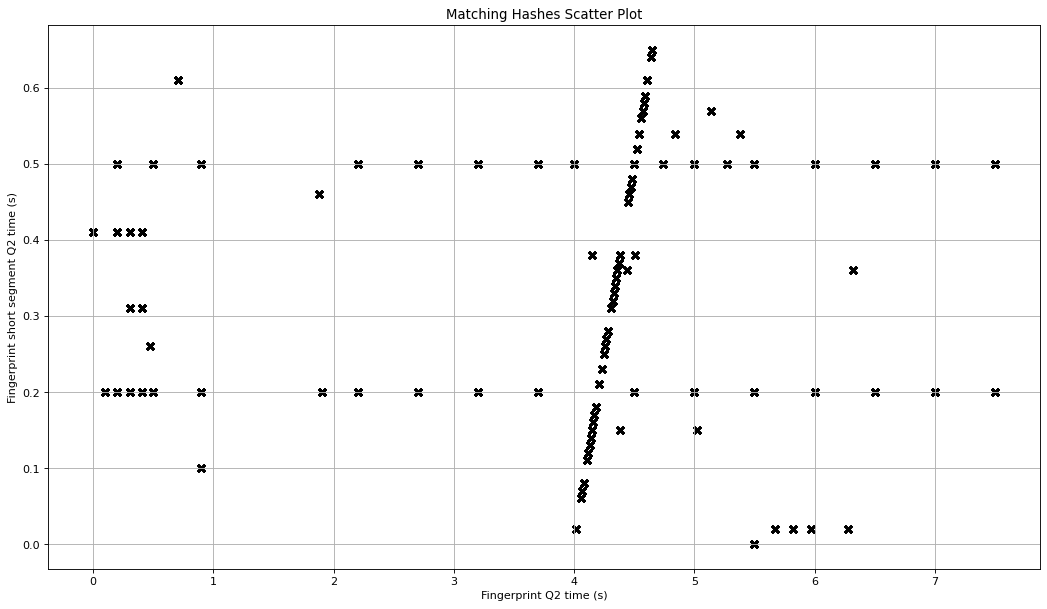

In [21]:
f1_times_longer, f2_times_shorter = zip(*comparison_fingerprints_same_audio)   
plt.figure(figsize=(16, 9), dpi=80)
plt.scatter(f1_times_longer, f2_times_shorter, marker='x', color='k')
plt.xlabel('Fingerprint Q2 time (s)')
plt.ylabel('Fingerprint short segment Q2 time (s)')
plt.title('Matching Hashes Scatter Plot')
plt.grid()
plt.show()

### Considerations
***
As can be seen, the diagonal appearing between seconds 4 and 5 shows the matches found between the two audio fingerprints. Being the audio on the y-axis just a segment of the audio of the x-axis it is clear that the diagonal is due to the fact that the algorithm recognized the similarities between the hashes and the final output shows that the one second audio segment correctly belongs to the 4 to 5 seconds interval of the full audio. As before there are some matches outside the diagonal but it may still be due to recurring patterns in the audio that cause hashes similarities. Overall these matches are very few and do not represent a problem in the final plot.
***

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

In [35]:
# add your code below
q4_anchor = compute_anchor_from_file('Q4.wav')
q4_fingerprint = compute_fingerprint(q4_anchor)
q2_anchor = compute_anchor_from_file('Q2.wav')
q2_fingerprint = compute_fingerprint(q2_anchor)

#TAKES 20 MINUTES TO COMPUTE

In [ ]:
comparison_fingerprints_audios = find_matching_hashes_medium_slow(q2_fingerprint, q4_fingerprint)

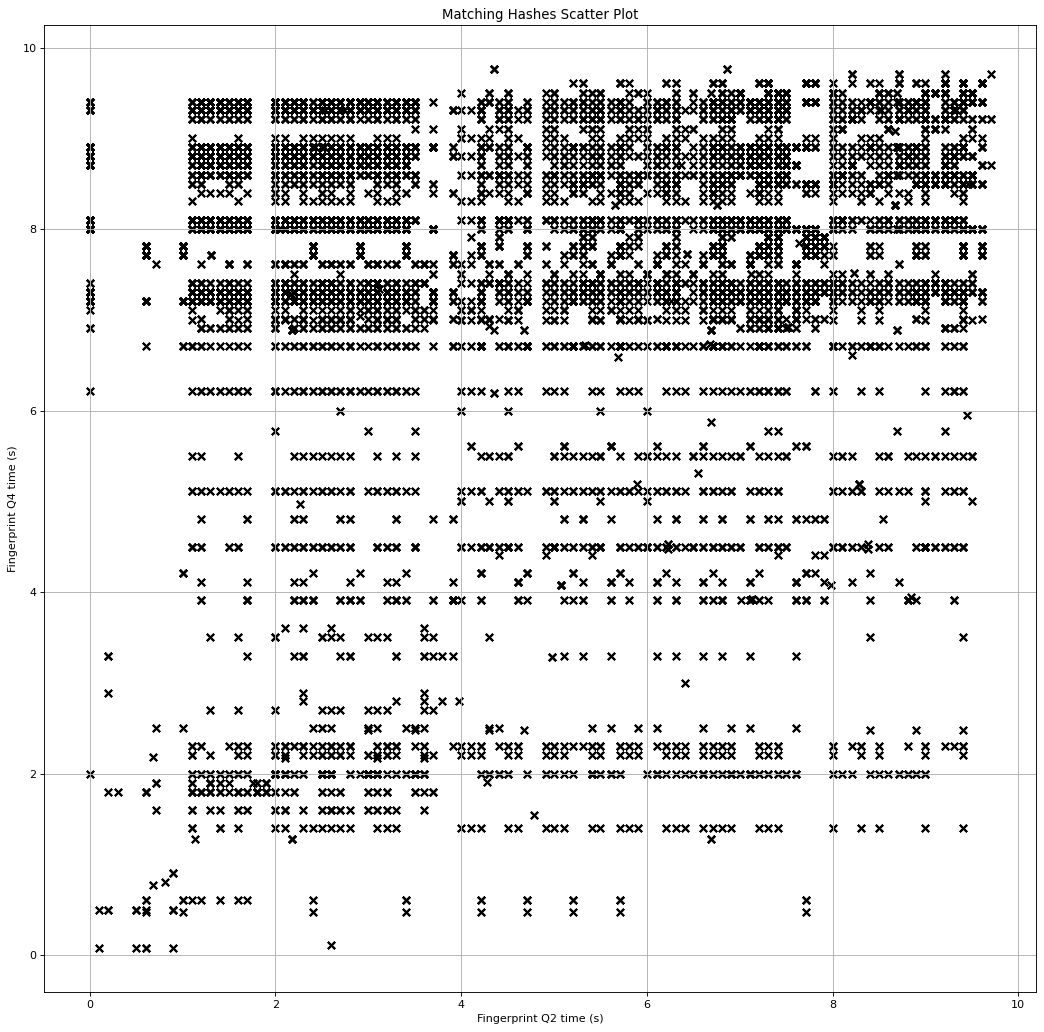

In [37]:
f2_times_audios, f4_times_audios = zip(*comparison_fingerprints_audios)  
plt.figure(figsize=(16, 16), dpi=80)
plt.scatter(f2_times_audios, f4_times_audios, marker='x', color='k')
plt.xlabel('Fingerprint Q2 time (s)')
plt.ylabel('Fingerprint Q4 time (s)')
plt.title('Matching Hashes Scatter Plot')
plt.grid()
plt.show()

### Considerations
***
As shown in the plot there are a lot of matches between the fingerprints of queries Q2 and Q4 but it is clear that they are two different audio tracks, in fact this time the matches are mostly scattered all around the plot. It is noticeable that the queries are different since this time it is not possible to find a correspondence along the diagonal as before. There are more matches in the ending seconds of Q4, maybe that means that there are some similarities to what is played throughout Q2. Overall, the matches may be still due to the fact that some hashes have similarities in the frequency contents and in the time delta that lead the sum of the magnitude differences between the dimensions of the hashes to be zero. There are more matches than before since the audio tracks are longer and there happen to be more coinciding hashes.
***

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.